In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [2]:
nt = 50           # number of temperature points
N=10             # size of lattice, N x N
eqsteps = 2500    # number of MC sweeps for equilibration
mcsteps = 4000    # number of MC sweeps for calculation

T = np.linspace(1.53, 3.28, nt)
Energy, Magnetization, SpecificHeat, Susceptibility = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n=1/(mcsteps*N*N)

In [3]:
state = 2*np.random.randint(2,size=(N,N))-1 
print(state) 

[[ 1 -1 -1  1  1 -1 -1 -1  1  1]
 [ 1  1  1  1 -1  1 -1  1  1 -1]
 [ 1 -1 -1  1  1 -1  1  1 -1  1]
 [-1 -1 -1  1 -1  1  1 -1 -1 -1]
 [ 1 -1  1 -1  1 -1 -1 -1  1  1]
 [-1  1 -1 -1 -1  1  1 -1  1  1]
 [ 1  1 -1  1 -1  1  1 -1 -1  1]
 [-1 -1  1 -1 -1  1 -1  1  1 -1]
 [ 1  1 -1 -1 -1  1  1  1 -1 -1]
 [-1  1  1  1 -1  1 -1  1  1 -1]]


In [4]:
for t in range(nt):
    Beta = 1/T[t]

    for i in range(eqsteps):
        for j in range(N):
            for k in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                sig_i =  state[a, b]
                sig_j = state[(a+1)%N,b] + state[(a-1)%N,b] + state[a,(b+1)%N] + state[a,(b-1)%N]
                delta_E = 2*sig_i*sig_j

                if delta_E <0:
                    sig_i *= -1
                elif rand() < np.exp(-delta_E*Beta):
                    sig_i *= -1
                state[a,b] = sig_i
    E=0
    M=0
    for i in range(mcsteps):
        for j in range(N):
            for k in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                sig_i =  state[a, b]
                sig_j = state[(a+1)%N,b] + state[(a-1)%N,b] + state[a,(b+1)%N] + state[a,(b-1)%N]
                delta_E = 2*sig_i*sig_j

                if delta_E <0:
                    sig_i *= -1
                elif rand() < np.exp(-delta_E*Beta):
                    sig_i *= -1
                state[a,b] = sig_i

        E += -sig_i*sig_j
        M += np.sum(state)
    
    Energy[t] = n*E
    Magnetization[t] = M*n



In [5]:
Energy

array([-0.038705, -0.03866 , -0.038665, -0.0384  , -0.038235, -0.03819 ,
       -0.038   , -0.03725 , -0.037265, -0.03663 , -0.036395, -0.035885,
       -0.035245, -0.03528 , -0.03472 , -0.03407 , -0.03314 , -0.03221 ,
       -0.03092 , -0.031065, -0.029965, -0.029545, -0.029105, -0.02709 ,
       -0.02619 , -0.02563 , -0.02489 , -0.02359 , -0.023475, -0.02208 ,
       -0.020995, -0.020415, -0.020365, -0.019595, -0.019255, -0.018805,
       -0.01822 , -0.017915, -0.01736 , -0.017   , -0.01703 , -0.016205,
       -0.01628 , -0.01574 , -0.01602 , -0.01529 , -0.014465, -0.01542 ,
       -0.01444 , -0.014535])

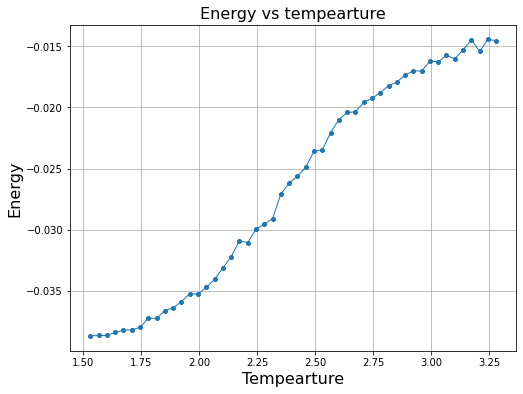

In [29]:
plt.figure(figsize=(8,6))
plt.plot(T,Energy,'o-',lw=1, ms=4)
plt.title('Energy vs tempearture',fontsize=16)
plt.xlabel('Tempearture',fontsize=16)
plt.ylabel('Energy',fontsize=16)
plt.grid()




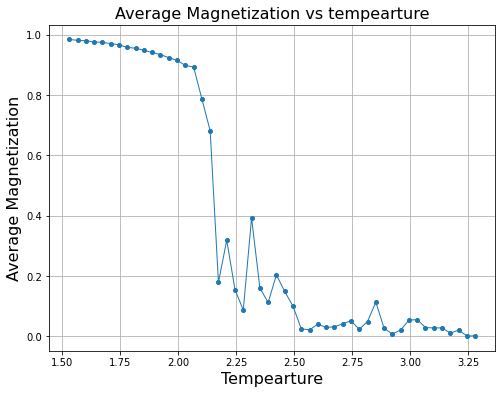

In [32]:
plt.figure(figsize=(8,6))
plt.plot(T,abs(Magnetization),'o-',lw=1, ms=4)
plt.title('Average Magnetization vs tempearture',fontsize=16)
plt.xlabel('Tempearture',fontsize=16)
plt.ylabel('Average Magnetization',fontsize=16)
plt.grid()

In [10]:
np.exp(-delta_E*Beta)
print(state)

[[ 1  1  1 -1 -1 -1 -1  1  1  1]
 [ 1 -1 -1 -1 -1 -1 -1  1  1  1]
 [ 1  1  1  1 -1 -1 -1  1  1  1]
 [ 1  1 -1 -1 -1  1 -1 -1  1  1]
 [-1 -1  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1  1 -1 -1 -1]
 [ 1 -1 -1  1 -1  1  1  1  1  1]]
